# Preparazione dei dati

## Import librerie e mount Google Drive

Viene effettuato il mounting della cartella associata all'account Google Drive, che contiene il dataset di immagini opportunamente diviso in 3 sotto-cartelle: ***train*** per le immagini di addestramento della rete, ***validation*** per la fase di validazione e ***test*** per il test.

Vengono importate le principali librerie e funzioni che saranno utilizzate per il progetto.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import tensorflow as tf
from skimage.transform import resize
from tensorflow import convert_to_tensor

## Caricamento dataset

Attraverso l'uso di *ImageDataGenerator*, vengono caricate in maniera automatica le immagini di addestramento, validazione e test. Si noti che viene effettuata la tecnica della **data augmentation** sulle immagini di training, in particolare applicando una rotazione random da -5 a 5 gradi, un ridimensionamento con fattore moltiplicativo random nel range [0.8, 1.2] e riflessione orizzontale random.

Per tutto il dataset, inoltre, è applicata una normalizzazione nel range [0, 1] e un ridimensionamento a 256x256 pixel. La dimensione della *batch* per le immagini di training e validazione è stata individuata sperimentalmente ed è pari a 32, mentre le immagini di test sono state raggruppate in *batch* da 10 immagini ciascuno.

In [ ]:
batch_size = 32
img_width, img_height = 256, 256

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1. / 255,zoom_range = 0.2,horizontal_flip = True, rotation_range=5)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/dataset.zip (Unzipped Files)/dataset/train',target_size=(img_width, img_height),batch_size=batch_size,class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1. / 255)
val_generator = val_datagen.flow_from_directory('/content/drive/MyDrive/dataset.zip (Unzipped Files)/dataset/validation',target_size=(img_width, img_height),batch_size=batch_size,class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/dataset.zip (Unzipped Files)/dataset/test',target_size=(img_width, img_height),batch_size=10,class_mode='categorical')

Found 17455 images belonging to 10 classes.
Found 4362 images belonging to 10 classes.
Found 4364 images belonging to 10 classes.


# Addestramento della rete neurale

## Creazione architettura

Viene definita l'architettura della rete neurale attraverso la tecnica del **fine-tuning**, sfruttando la rete *ResNet152V2*, 
pre-addestrata sul dataset ImageNet, una raccolta di circa 14 milioni di immagini annotate manualmente in diverse categorie. I parametri della parte convolutiva di ResNet152V2 non sono modificati durante il training. Questa scelta dipende dalla somiglianza del dataset utilizzato con ImageNet che contiene tutte le classi presenti.

Oltre alla rete base, vengono aggiunti 3 strati **Fully-Connected**, che compongono il classificatore, di cui i primi due con funzione di attivazione non lineare *ReLU* e l'ultimo con la funzione *Softmax*, che normalizza l'uscita per ottenere valori non negativi e a somma unitaria. In questo modo, si ha come risultato finale un vettore di 10 elementi, ognuno dei quali rappresenta la probabilità che l'immagine in ingresso appartenga alla classe i-esima.

Infine, la rete neurale è stata compilata con la loss function *CategoricalCrossentropy* e l'ottimizzatore *Adam*. Per quanto riguarda il **learning rate** della loss function, è stato selezionato il valore di default.

In [ ]:
def create_model():
  base_model = tf.keras.applications.ResNet152V2(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))#fine tuning
  
  for layer in base_model.layers:
    layer.trainable = False

  model = tf.keras.models.Sequential()
  model.add(base_model)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(2048, activation='relu'))
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='softmax')) 

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

  return model

In [ ]:
network = create_model()
network.summary()

234553344/234545216 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              268437504 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 327,823,370
Trainable params: 269,491,722
Non-trainable params: 58,331,648
_________________________________________________________________


## Training rete 

La neural network è stata addestrata con il metodo *fit_generator*, sfruttando i generatori **train_generator** e **val_generator** definiti durante la fase di caricamento del dataset. Al fine di ottenere le migliori prestazioni possibili dalla rete, è stato scelto un numero di *epoche* pari a 50.

In [ ]:
network.fit_generator(train_generator, validation_data=val_generator, epochs=50,verbose=True)

In [ ]:
network.load_weights("/content/drive/MyDrive/pesi_progetto_resnet")

In [ ]:
network.save_weights("/content/drive/MyDrive/pesi_progetto_resnet")

# Valutazione delle prestazioni

Viene definita una lista di 10 stringhe, che rappresentano le classi usate per la classificazione del dataset, ed un *dictionary* che consente di passare facilmente da label a classi e viceversa

In [ ]:
classes = ['Cane','Cavallo','Elefante','Farfalla', 'Gallina', 'Gatto', 'Mucca', 'Pecora', 'Ragno', 'Scoiattolo']

classes_dictionary = {
  'cane' : np.array([[1,0,0,0,0,0,0,0,0,0]]),
  'cavallo' : np.array([[0,1,0,0,0,0,0,0,0,0]]),
  'elefante' : np.array([[0,0,1,0,0,0,0,0,0,0]]),
  'farfalla' : np.array([[0,0,0,1,0,0,0,0,0,0]]),
  'gallina' : np.array([[0,0,0,0,1,0,0,0,0,0]]),
  'gatto' : np.array([[0,0,0,0,0,1,0,0,0,0]]),
  'mucca' : np.array([[0,0,0,0,0,0,1,0,0,0]]),
  'pecora' : np.array([[0,0,0,0,0,0,0,1,0,0]]),
  'ragno' : np.array([[0,0,0,0,0,0,0,0,1,0]]),
  'scoiattolo' : np.array([[0,0,0,0,0,0,0,0,0,1]])
}

Viene effettuato il **test** della rete neurale con un batch di 10 immagini. Dopo aver calcolato l'array di label predetto della rete e quello reale, sono state valutate le prestazioni della CNN in termini di accuratezza.

In particolare, è stata elaborata la ***matrice di confusione***, una matrice 10x10 che permette di capire quante immagini di test sono state classificate bene e quante invece sono state assegnate alla classe sbagliata. 

In [ ]:
imgs = next(test_generator)

predictions = network.predict(imgs[0])
p = np.argmax(predictions,1)
l = np.argmax(imgs[1],1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(l, p)
print(cm)

accuracy = np.mean(p==l)
print(accuracy)

a = np.int64(p==l)
mistakes = list()
for i in range(len(a)):
  if(a[i]!= True):
    mistakes.append((imgs[0][i],predictions[i]))

for i in mistakes:
  plt.figure(figsize=(30,10))
  plt.title(classes[np.argmax(i[1])])
  plt.subplot(121);plt.imshow(i[0])
  plt.subplot(122);plt.bar(np.arange(10), i[1]); plt.xticks(np.arange(10), classes)

[[3 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]]
1.0


Testando la rete sull'intero testset di oltre 4000 immagini, si ottiene una *accuracy* del circa 96% e la seguente *confusion matrix*:



$ C_{m,n} =
 \begin{pmatrix}
  709 & 4 & 2 & 5 & 0 & 7 & 14 & 3 & 4 & 1 \\
  1 & 388 & 0 & 0 & 0 & 0 & 8 & 2 & 0 & 0 \\
  0 & 1 & 215 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
  2 & 1 & 0 & 315 & 0 & 0 & 0 & 0 & 6 & 0 \\
  5 & 3 & 0 & 4 & 453 & 0 & 9 & 0 & 2 & 0 \\
  9 & 2 & 3 & 0 & 0 & 230 & 5 & 1 & 1 & 8 \\
  1 & 0 & 1 & 0 & 0 & 0 & 272 & 6 & 0 & 0 \\
  5 & 1 & 1 & 0 & 0 & 2 & 20 & 244 & 0 & 0 \\
  1 & 3 & 0 & 2 & 1 & 0 & 1 & 0 & 726 & 0 \\
  0 & 0 & 1 & 0 & 0 & 2 & 0 & 0 & 0 & 286 \\
 \end{pmatrix}$

# Attacco con la tecnica FGSM

Dopo aver allenato la rete, si passa alla fase di attacco. Si vuole applicare una perturbazione all'immagine di ingresso tale che la differenza visiva con l'immagine di partenza sia **minima**, ma allo stesso tempo la loss function diventi **grande**, portando quindi la rete neurale a classificare male le immagini.

Al fine di costruire questa perturbazione si è utilizzata la tecnica del FGSM:

$$\eta = \epsilon sign(\nabla_{x}J(\theta,y,x)) $$

La perturbazione è dunque pari al prodotto di  $ \epsilon $ per il **gradiente** della loss function $J(\theta,y,x)$ rispetto all'immagine di ingresso $x$. 

## Attacco non target

Viene definita la funzione di attacco non target. Inizialmente, sia l'immagine in ingresso che l'array di label ad essa associato sono convertiti in tensori. Attraverso il metodo *watch* di **GradientTape**, si inizializza il calcolo del gradiente, in modo da assicurarsi che l'immagine in ingresso venga tracciata da GradientTape.

Dopo aver calcolato la *loss function*, viene elaborato il gradiente della funzione di perdita rispetto all'ingresso e la perturbazione da applicare all'immagine. 

In [ ]:
def non_targeted_attack(input_image, input_label, model,e=0.01, loss_function = tf.keras.losses.CategoricalCrossentropy()):

  input_image = convert_to_tensor(input_image)
  input_label = convert_to_tensor(input_label)

  with tf.GradientTape() as g:
    g.watch(input_image) 
    prediction = model(input_image) 
    loss = loss_function(input_label, prediction)
    
  gradient = g.gradient(loss, input_image)
  perturbation = e*np.sign(gradient.numpy())

  return perturbation

### Metodo iterativo 

Il metodo iterativo si basa sull'attaccare la rete neurale per un determinato numero di volte, pari ad *iterations*, sommando ad ogni ciclo la perturbazione generata dall'attacco all'immagine in ingresso. L'immagine perturbata viene quindi sottoposta al successivo attacco, che genererà una nuova perturbazione $\eta$.

Si noti che viene effettuata un'operazione di *clipping* sull'immagine in modo tale che la perturbazione non sia mai maggiore di $|\epsilon|$. Inoltre, alla fine delle iterazioni viene specificata un ulteriore *clipping* dell'immagine in modo che rimanga nel range [0,1].

In [ ]:
def iterative_attack(attack, input_image, input_label, model, iterations, e, loss_function=tf.keras.losses.CategoricalCrossentropy()):
  fake_img = input_image.copy()
  for i in range(iterations):
    n = attack(fake_img, input_label, model, e, loss_function)
    fake_img += n
    fake_img = np.clip(fake_img, input_image-e, input_image+e)

  fake_img = np.clip(fake_img, 0, 1)
  return fake_img

Viene testato l'attacco non target iterativo su una generica immagine del test set.

Le due immagini differiscono di una quantità al massimo pari a: 0.01000000536441803


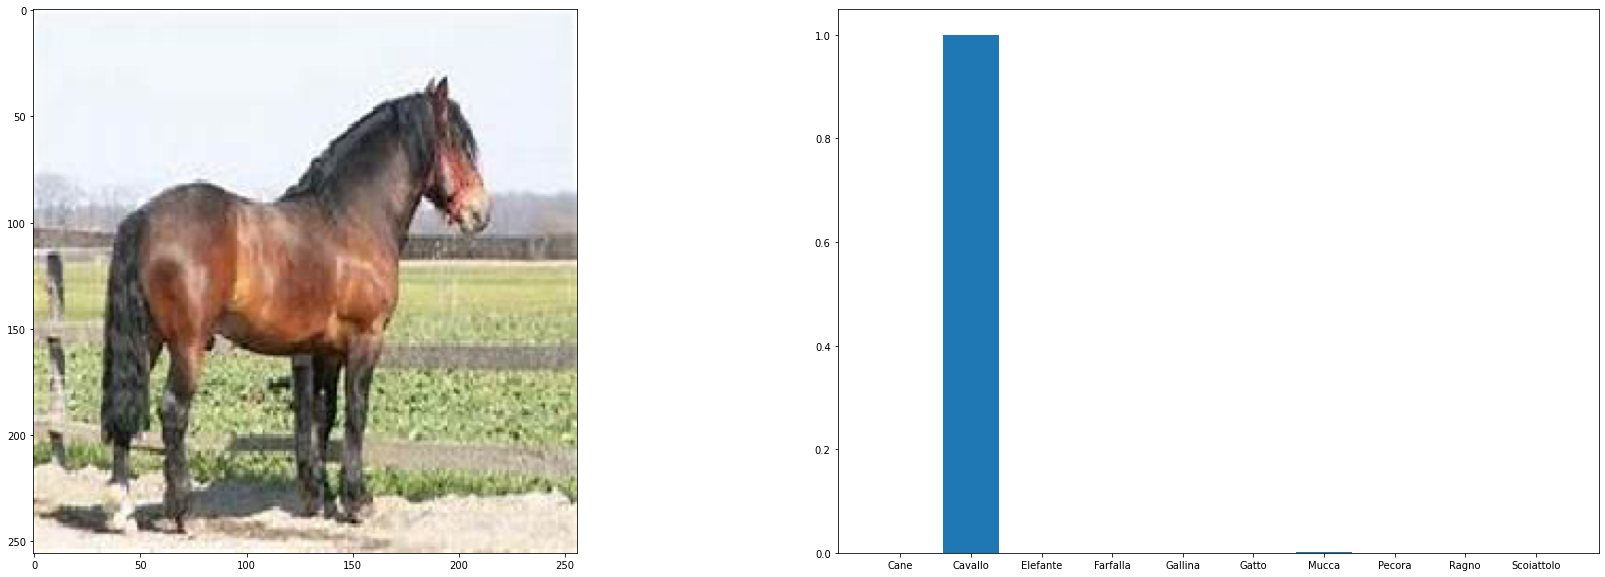

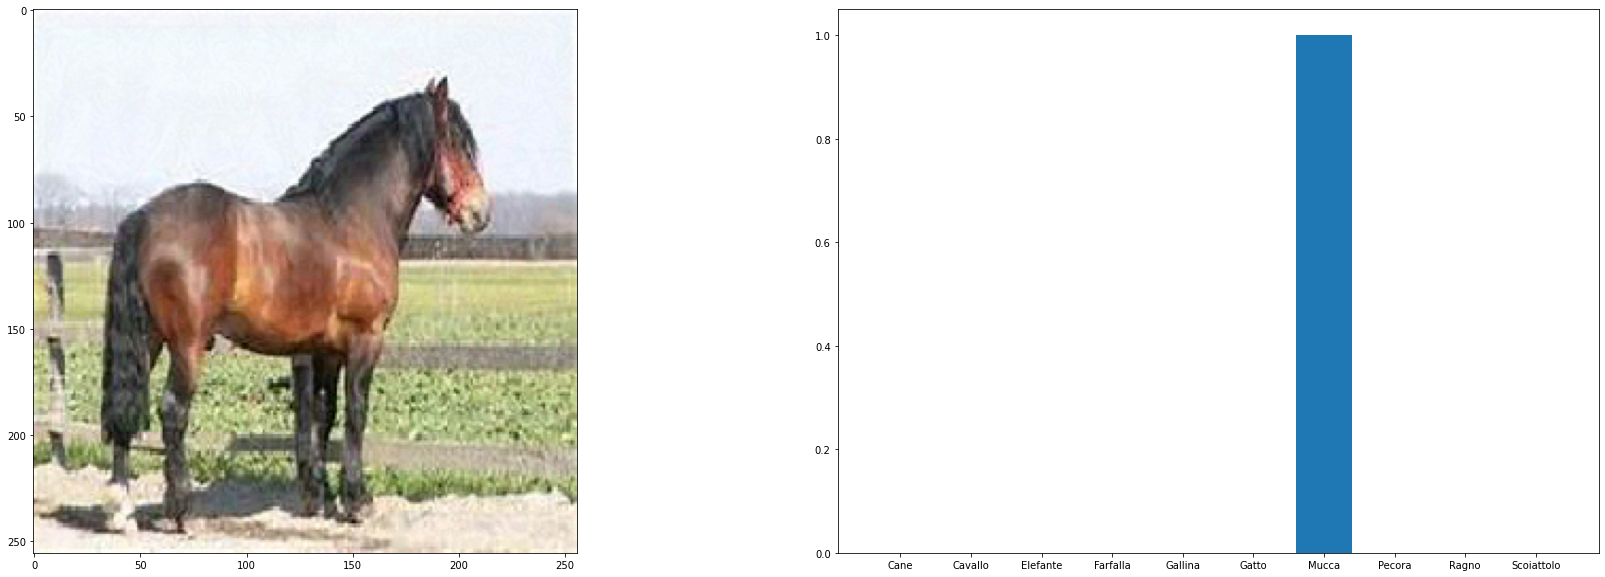

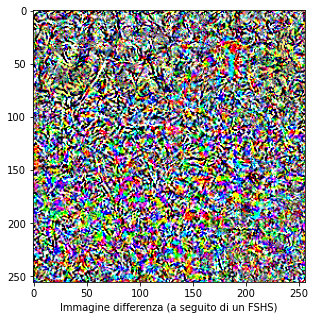

In [ ]:
imgs = next(test_generator)

x_true = imgs[0]
orig_img = x_true[0:1].copy()
fake_img = iterative_attack(non_targeted_attack, orig_img, imgs[1][0:1],network,10, 0.01)

pred = network.predict(orig_img)
fake_pred = network.predict(fake_img)

plt.figure(figsize=(30,10));plt.subplot(121); plt.imshow(orig_img[0]); plt.subplot(122); plt.bar(range(10), pred[0]); plt.xticks(np.arange(10), classes);
plt.figure(figsize=(30,10));plt.subplot(121); plt.imshow(fake_img[0]); plt.subplot(122); plt.bar(range(10), fake_pred[0]); plt.xticks(np.arange(10), classes);

diff = fake_img[0]-orig_img[0]

plt.figure(figsize=(15,5));plt.imshow((diff-np.min(diff))/(np.max(diff)-np.min(diff))); plt.xlabel("Immagine differenza (a seguito di un FSHS)")

print("Le due immagini differiscono di una quantità al massimo pari a: {}".format(np.max(np.abs(fake_img[0] - orig_img[0]))))

## Attacco target

Nell'attacco **target**, le immagini vengono perturbate in modo da essere classificate erroneamente come appartenenti ad una specifica classe scelta dall'attaccante. 

Al fine di realizzare l'attacco target, si utilizza una variante del *FSGM*, che, invece di costruire una perturbazione che aumenti la loss function $J(\theta,y,x)$, crea un rumore che minimizza la $J(\theta,y_{t},x)$, dove $y_{t}$ rappresenta l'array di label target.
La perturbazione sarà dunque calcolata come: $$\eta = -\epsilon sign(\nabla_{x}J(\theta,y_{t},x)) $$

Viene quindi definita la funzione di attacco che, a differenza di quella non target, calcola la loss function a partire da $y_{t}$. Si osservi inoltre che ora la perturbazione è l'opposto della perturbazione generata dall'attacco non target.

In [ ]:
def targeted_attack(input_image, target_label, model,e, loss_function = tf.keras.losses.CategoricalCrossentropy()):
  input_image = convert_to_tensor(input_image)
  target_label = convert_to_tensor(target_label)

  with tf.GradientTape() as g:
    g.watch(input_image) #inizializzo per fare il gradiente
    prediction = model(input_image) 
    loss = loss_function(target_label, prediction)

  gradient = g.gradient(loss, input_image)#calcola il gradiente della loss rispetto all'ingresso x
  perturbation = -e*np.sign(gradient.numpy())
  return perturbation

Viene usata la funzione di attacco target su un immagine del test set. La classe target è "*gatto*", indicata come parametro di ingresso della funzione *iterative_attack*.

Dopo aver predetto l'array di label dell'immagine originale e quello dell'immagine perturbata, le due immagini vengono visualizzate a video e viene aggiunto un grafico a barre che mostra chiaramente come sia cambiata la classe predetta dalla rete neurale a seguito dell'attacco.

Le due immagini differiscono di una quantità al massimo pari a: 0.02000001072883606


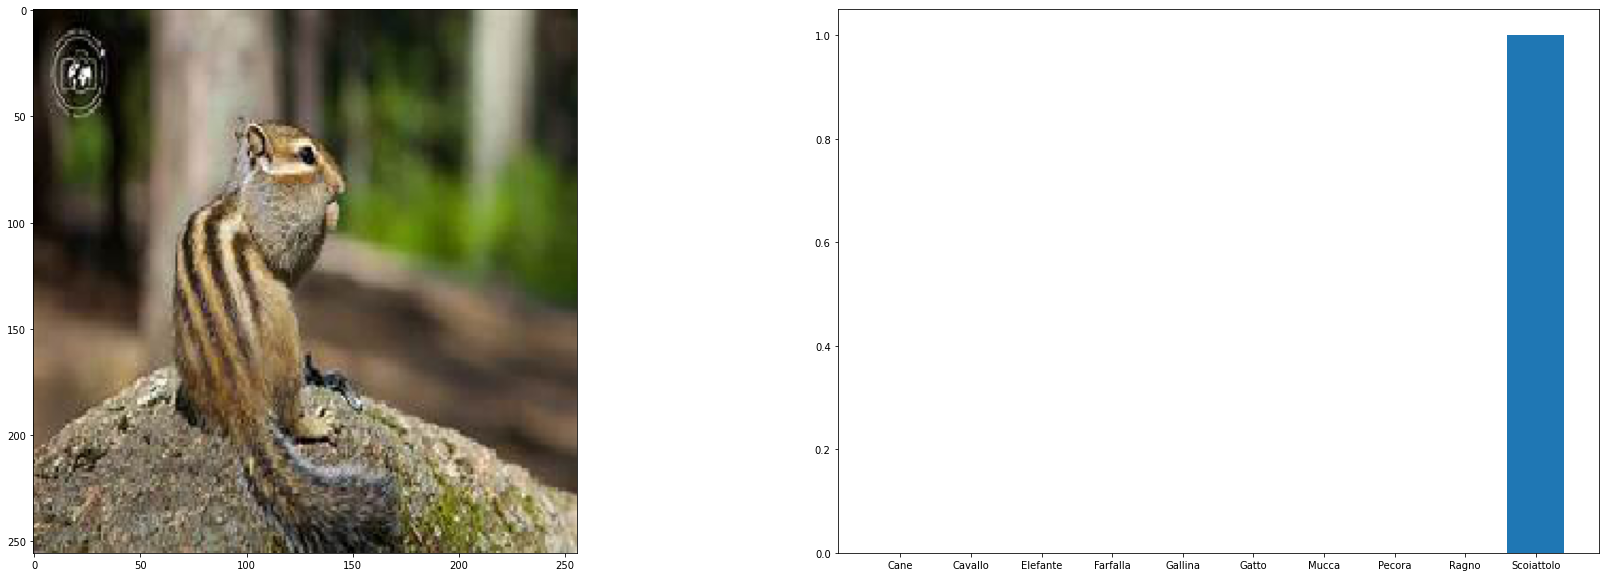

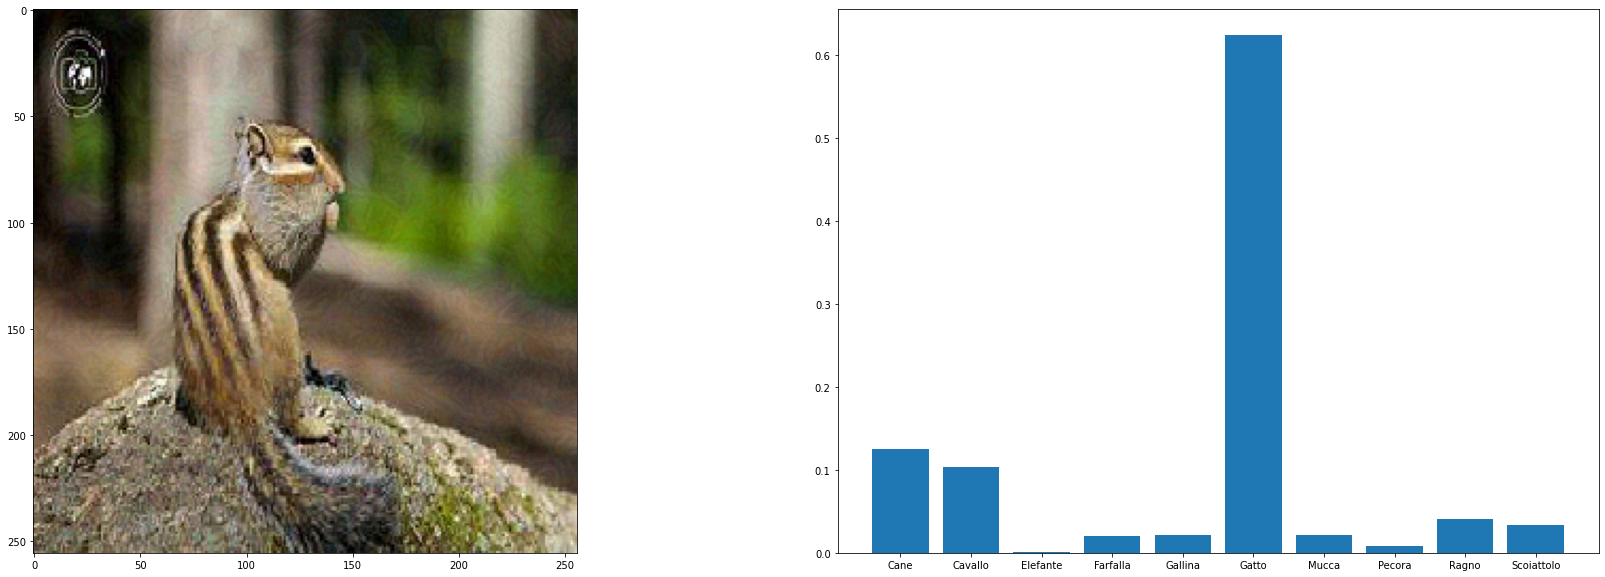

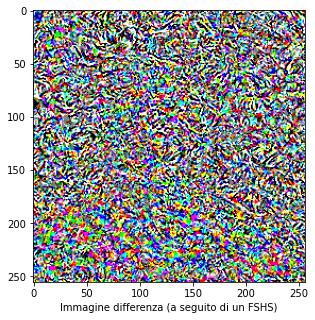

In [ ]:
imgs = next(test_generator)

x_true = imgs[0]
orig_img = x_true[0:1].copy()
fake_img = iterative_attack(targeted_attack, orig_img, classes_dictionary['gatto'],network,20, 0.02)

pred = network.predict(orig_img)
fake_pred = network.predict(fake_img)

plt.figure(figsize=(30,10));plt.subplot(121); plt.imshow(orig_img[0]); plt.subplot(122); plt.bar(range(10), pred[0]); plt.xticks(np.arange(10), classes);
plt.figure(figsize=(30,10));plt.subplot(121); plt.imshow(fake_img[0]); plt.subplot(122); plt.bar(range(10), fake_pred[0]); plt.xticks(np.arange(10), classes);

diff = fake_img[0]-orig_img[0]

plt.figure(figsize=(15,5));plt.subplot(121); plt.imshow((diff-np.min(diff))/(np.max(diff)-np.min(diff))); plt.xlabel("Immagine differenza (a seguito di un FSHS)")

print("Le due immagini differiscono di una quantità al massimo pari a: {}".format(np.max(np.abs(fake_img[0] - orig_img[0]))))


# Attacco black box

Finora sono stati effettuati attacchi **white box**, nel senso che si conosceva già la **rete target** da attaccare. Spesso, nella realtà dei fatti, non è così.

Gli attacchi ***black box*** prevedono di costruire perturbazioni avversarie per una rete neurale di cui non si conosce l'architettura interna. Una tecnica che si può utilizzare è progettare un attacco per una rete surrogata allenata ad hoc sullo stesso *training set* della rete target. In questo modo, si può vedere come l'attacco progettato per la rete surrogata, sempre effettuato con la tecnica *FGSM*, generalizzi in modo molto efficiente l'attacco sulla rete black blox

## Definizione e training della rete black box

Viene costruita la rete surrogata utilizzando la tecnica del **fine-tuning**, sfruttando la rete VGG19, addrestata su ImageNet. Dopo il modello base, sono stati aggiunti tre layer ***Fully-Connected*** intervallati da altri tre layer di ***BatchNormalization***, con lo scopo di normalizzare media e varianza dei suoi input, mantenendo in uscita una media vicina a 0 e una deviazione standard vicina ad 1.

In [ ]:
def create_blackbox_model():
  base_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))#fine tuning
  
  for layer in base_model.layers[:-3]:
    layer.trainable = False

  model = tf.keras.models.Sequential()
  model.add(base_model)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024, activation='relu'))
  model.add(tf.keras.layers.BatchNormalization()) #normalizza media e varianza
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(250, activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(10, activation='softmax')) 

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

  return model

In [ ]:
bb_network = create_blackbox_model()
bb_network.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_______________________________________________________

In [ ]:
bb_network.fit_generator(train_generator, validation_data=val_generator, epochs=15,verbose=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
546/546 [==============================] - 1159s 2s/step - loss: 0.5574 - accuracy: 0.8174 - val_loss: 0.5346 - val_accuracy: 0.8375
Epoch 2/15
546/546 [==============================] - 294s 538ms/step - loss: 0.4364 - accuracy: 0.8568 - val_loss: 0.4578 - val_accuracy: 0.8551
Epoch 3/15
546/546 [==============================] - 291s 532ms/step - loss: 0.3736 - accuracy: 0.8783 - val_loss: 0.5099 - val_accuracy: 0.8425
Epoch 4/15
546/546 [==============================] - 289s 530ms/step - loss: 0.3347 - accuracy: 0.8921 - val_loss: 0.4955 - val_accuracy: 0.8505
Epoch 5/15
546/546 [==============================] - 289s 530ms/step - loss: 0.2951 - accuracy: 0.9043 - val_loss: 0.5330 - val_accuracy: 0.8439
Epoch 6/15
546/546 [==============================] - 289s 530ms/step - loss: 0.2542 - accuracy: 0.9181 - val_loss: 0.4692 - val_accuracy: 0.8634
Epoch 7/15
546/546 [==============================] - 290s 530ms/step - loss: 0.2278 - accuracy: 0.9248 - val_loss: 0.5647 - v

In [ ]:
bb_network.load_weights("/content/drive/MyDrive/pesi_progetto_vggnet")

In [ ]:
bb_network.save_weights("/content/drive/MyDrive/pesi_progetto_vggnet")

Vengono valutate le prestazioni della rete black box, attraverso il calcolo dell'accuracy e della confusion matrix.

In [ ]:
imgs = next(test_generator)

predictions = bb_network.predict(imgs[0])
p = np.argmax(predictions,1)
l = np.argmax(imgs[1],1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(l, p)
print(cm)

accuracy = np.mean(p==l)
print(accuracy)

[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 1 0 2 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 1]]
0.9


##Creazione degli esempi avversari

Viene testata la tecnica *non target iterativa* su un'immagine del test set e viene costruito un esempio avversario per la rete surrogata, verificandone l'efficacia nel far sbagliare il modello target.

Si noti che l'attacco è generato sulla **rete surrogata**, ma le prestazioni vengono valutate sulla **black box**. In particolare, si effettuano le predizioni dell'array di label, sia dell'immagine originale che di quella perturbata, proprio sul modello *bb_network*, che si suppone di non conoscere.

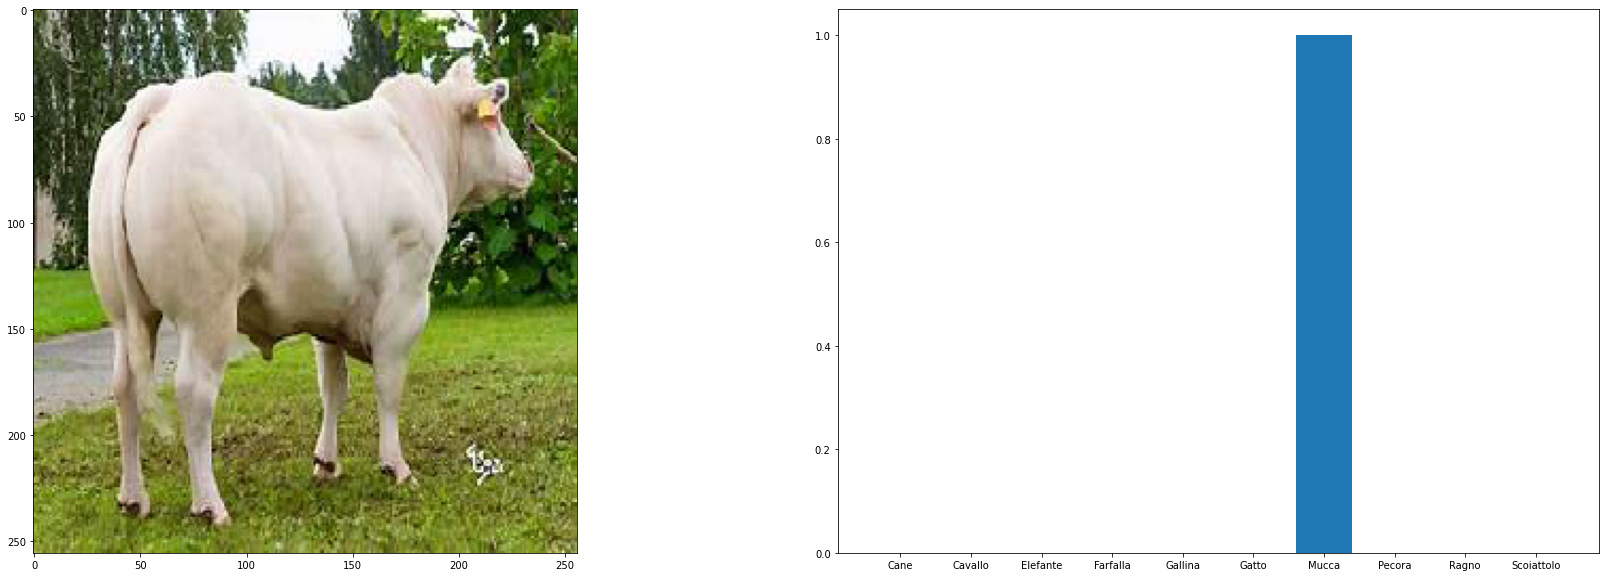

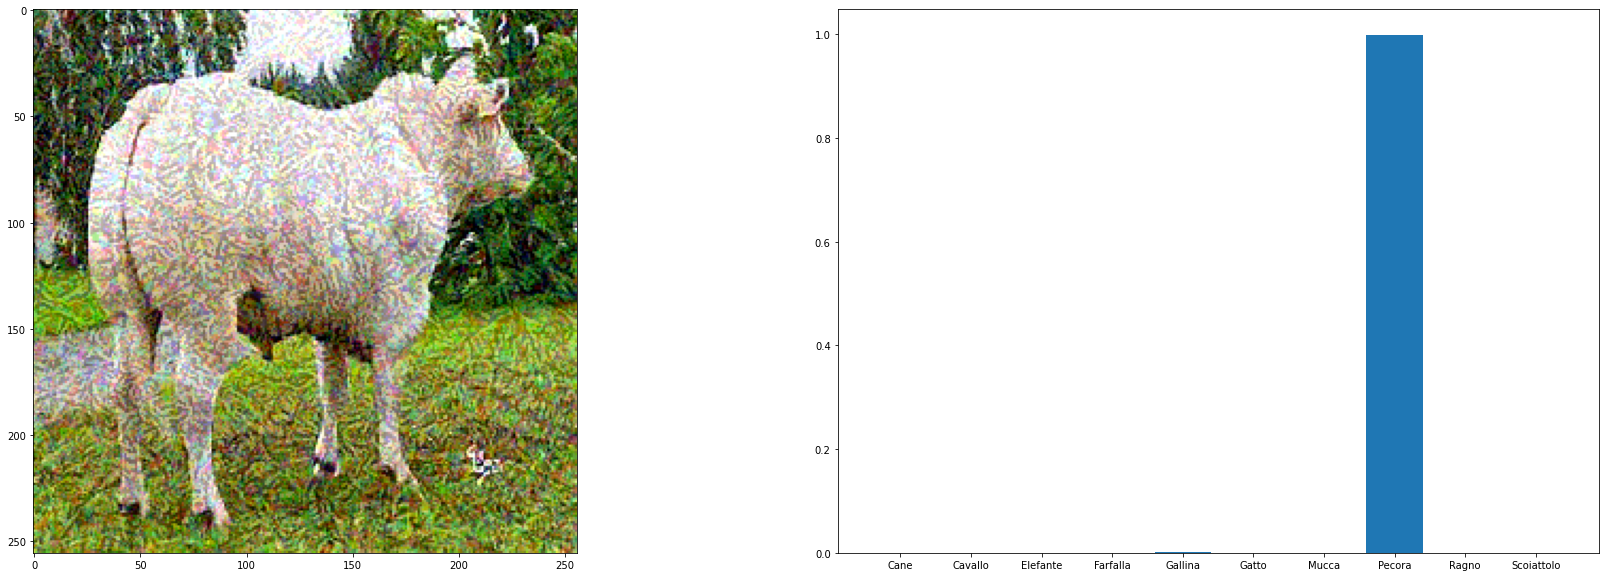

In [ ]:
imgs = next(test_generator)

x_true = imgs[0]
orig_img = x_true[0:1].copy()
fake_img = iterative_attack(non_targeted_attack, orig_img, imgs[1][0:1],network,10, 0.15)
pred = bb_network.predict(orig_img)
fake_pred = bb_network.predict(fake_img)

plt.figure(figsize=(30,10))
plt.subplot(121); plt.imshow(orig_img[0])
plt.subplot(122); plt.bar(range(10), pred[0]); plt.xticks(np.arange(10), classes);

plt.figure(figsize=(30,10))
plt.subplot(121); plt.imshow(fake_img[0])
plt.subplot(122); plt.bar(range(10), fake_pred[0]); plt.xticks(np.arange(10), classes);

#Valutazione delle prestazioni dopo l'attacco

## Attacco non target

Viene valutata l'accuracy prima e dopo l'attacco su un batch del test set attraverso la tecnica dell'attacco *non target* effettuato con tecnica *FGSM*.

In [ ]:
imgs = next(test_generator)
x_true = imgs[0][0:10]
labels = imgs[1][0:10]

x_fake = x_true + non_targeted_attack(x_true.copy(), labels, network,0.05)
prediction = network.predict(x_true)
prediction_fake = network.predict(x_fake)

accuracy = np.mean(np.argmax(labels,1) == np.argmax(prediction,1))
accuracy_fake = np.mean(np.argmax(labels,1) == np.argmax(prediction_fake,1))

print("La accuracy prima dell'attacco è pari a : {}%, quella dopo l'attacco è invece pari a: {}%".format(accuracy*100,accuracy_fake*100))

La accuracy prima dell'attacco è pari a : 90.0%, quella dopo l'attacco è invece pari a: 40.0%


## Attacco non target iterativo

Vengono valutate le performance su un intero batch prima e dopo l'attacco.

In [ ]:
imgs = next(test_generator)
x_true = imgs[0][0:10]
labels = imgs[1][0:10]

x_fake = iterative_attack(non_targeted_attack, x_true.copy(), labels, network, 10, 0.01)
prediction = network.predict(x_true)
prediction_fake = network.predict(x_fake)

accuracy = np.mean(np.argmax(labels,1) == np.argmax(prediction,1))
accuracy_fake = np.mean(np.argmax(labels,1) == np.argmax(prediction_fake,1))

print("La accuracy prima dell'attacco è pari a : {}%, quella dopo l'attacco è invece pari a: {}%".format(accuracy*100,accuracy_fake*100))

La accuracy prima dell'attacco è pari a : 80.0%, quella dopo l'attacco è invece pari a: 10.0%


Viene calcolata la accuracy su 10 batch del test set. Si noti che l'accuracy prima dell'attacco e quella successiva all'attacco vengono calcolate ad ogni nuovo batch ed accumulate in due vettori, per cui alla fine verrà effettuata la media per ottenerne dei valori complessivi.



In [ ]:
from tqdm import tqdm
acc = list()
fake_acc = list()

for i in tqdm(range(10)):
  imgs = next(test_generator)
  
  x_true = imgs[0]
  lables = imgs[1]

  x_fake = iterative_attack(non_targeted_attack, x_true.copy(), lables, network, 5, 0.05)
  prediction = network.predict(x_true)
  prediction_fake = network.predict(x_fake)

  accuracy = np.mean(np.argmax(lables,1) == np.argmax(prediction,1))
  accuracy_fake = np.mean(np.argmax(lables,1) == np.argmax(prediction_fake,1))

  acc.append(accuracy)
  fake_acc.append(accuracy_fake)

acc = np.mean(acc)
fake_acc = np.mean(fake_acc)
print("La accuracy prima dell'attacco non target iterativo è pari a : {}%, quella dopo l'attacco è invece pari a: {}%".format(acc*100,fake_acc*100))

100%|██████████| 10/10 [00:52<00:00,  5.21s/it]

La accuracy prima dell'attacco non target iterativo è pari a : 93.0%, quella dopo l'attacco è invece pari a: 23.0%


Vengono analizzate le performance del classificatore dopo l'attacco *iterativo non target* al variare del numero di iterazioni, con un valore di $ \epsilon $ fissato.




In [ ]:
imgs = next(test_generator)

x_true = imgs[0]
lables = imgs[1]
iterations = np.arange(0,20,1)
res_i = list()

for i in iterations:
  x_fake = iterative_attack(non_targeted_attack, x_true.copy(), lables, network, i, 0.05)
  prediction_fake = network.predict(x_fake)
  accuracy_fake = np.mean(np.argmax(lables,1) == np.argmax(prediction_fake,1))
  res_i.append(accuracy_fake)

res_i = np.array(res_i)


Vengono analizzate le performance del classificatore dopo l'attacco *iterativo non target* al variare della perturbazione applicata alle immagini, considerando costante il numero di iterazioni, pari a 10.


In [ ]:
imgs = next(test_generator)

x_true = imgs[0]
lables = imgs[1]
noises = np.arange(0,0.3,0.02)
res_n = list()

for i in noises:
  x_fake = iterative_attack(non_targeted_attack, x_true.copy(), lables, network, 10, i)
  prediction_fake = network.predict(x_fake)
  accuracy_fake = np.mean(np.argmax(lables,1) == np.argmax(prediction_fake,1))
  res_n.append(accuracy_fake)

res_n = np.array(res_n)


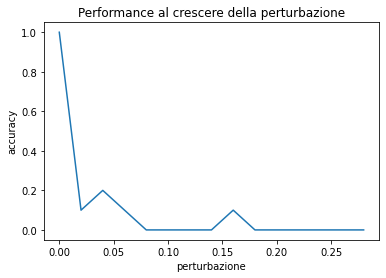

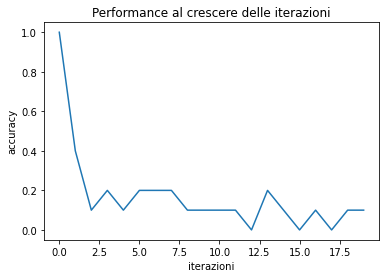

In [ ]:
plt.figure(); plt.plot(noises, res_n); plt.xlabel('perturbazione'); plt.ylabel('accuracy'); plt.title('Performance al crescere della perturbazione'); plt.show();
plt.figure(); plt.plot(iterations ,res_i); plt.xlabel('iterazioni'); plt.ylabel('accuracy'); plt.title('Performance al crescere delle iterazioni'); plt.show();

## Attacco target iterativo

Viene testato l'attacco target su cinque coppie di classi a scelta per verificarne l'efficacia. I risultati sono nel complesso positivi visto che la maggior parte delle immagini viene confusa dalla rete neurale come appartenente ad un'altra classe. Per esempio, alla terza immagine, che è chiamaramente una mucca, viene applicata una perturbazione impercettibile tale da essere confusa con un ragno. 

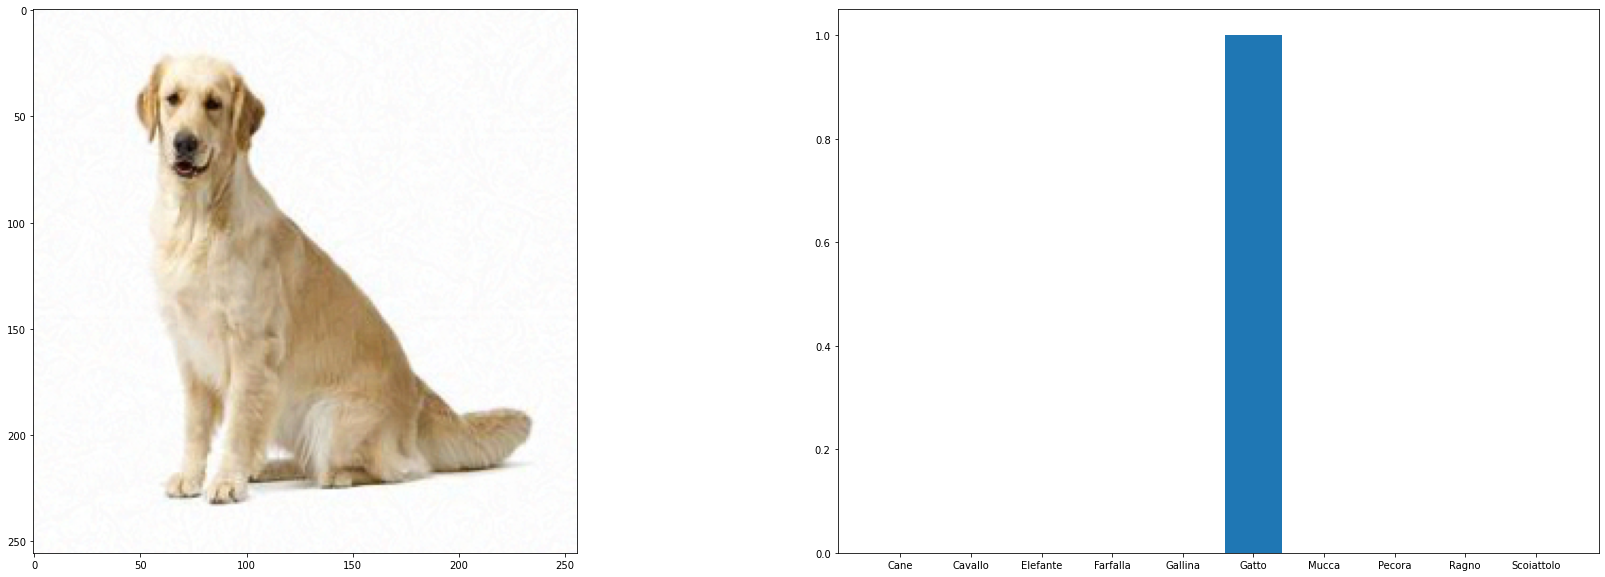

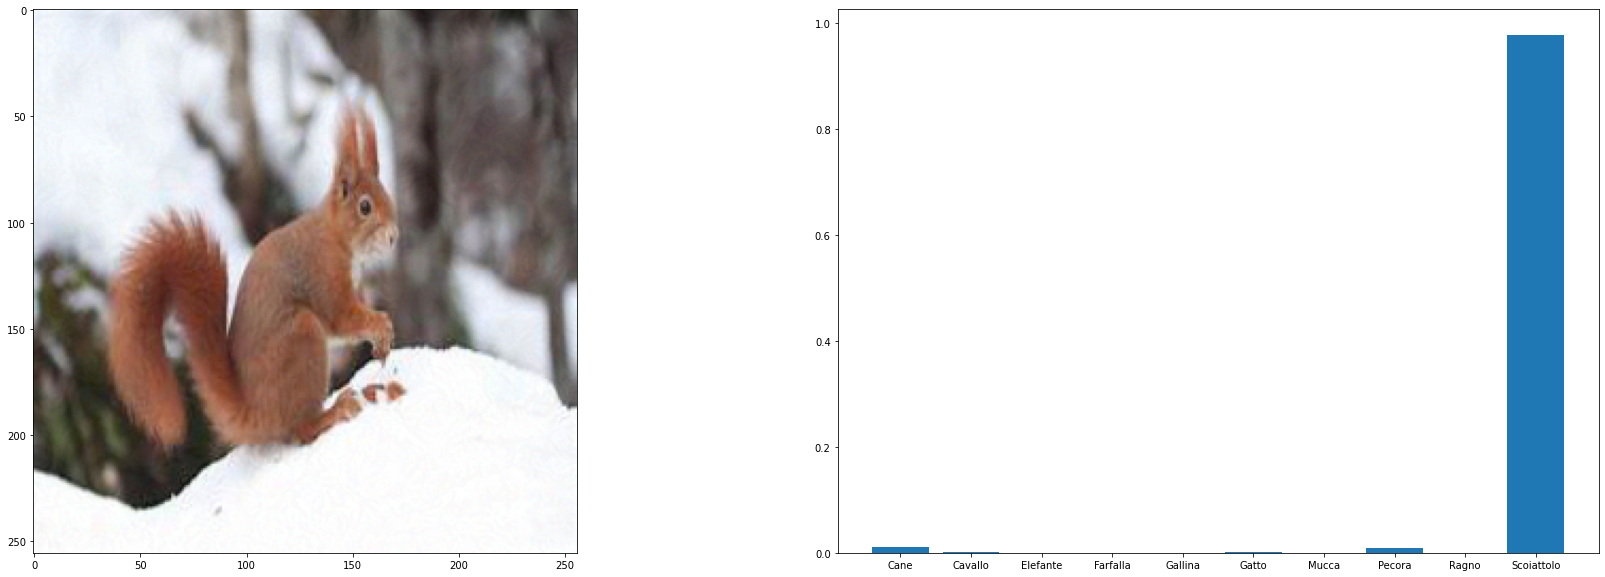

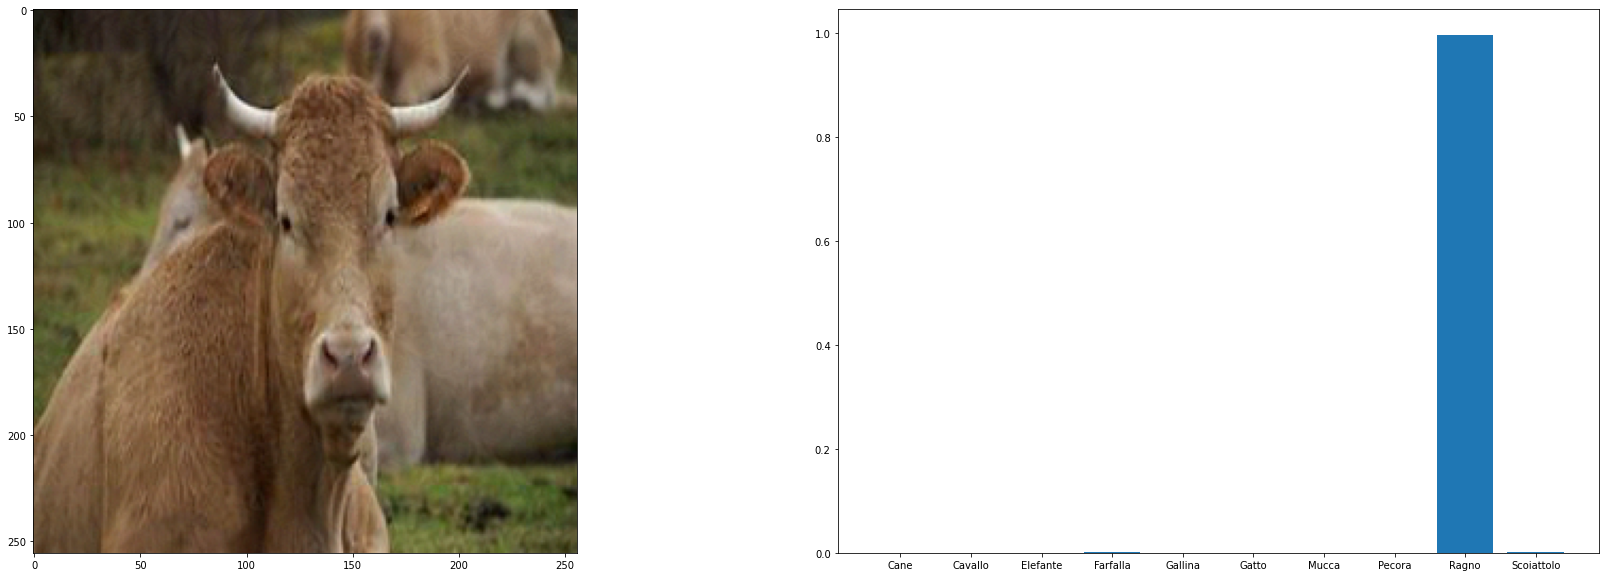

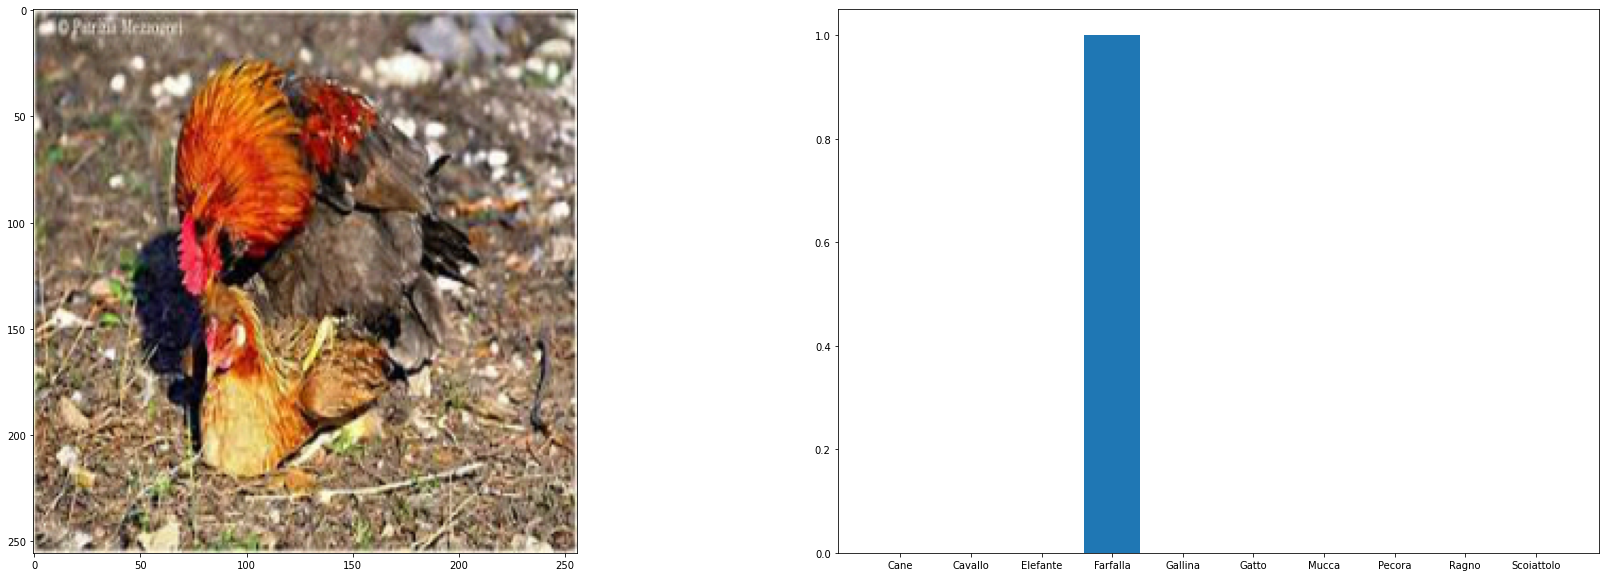

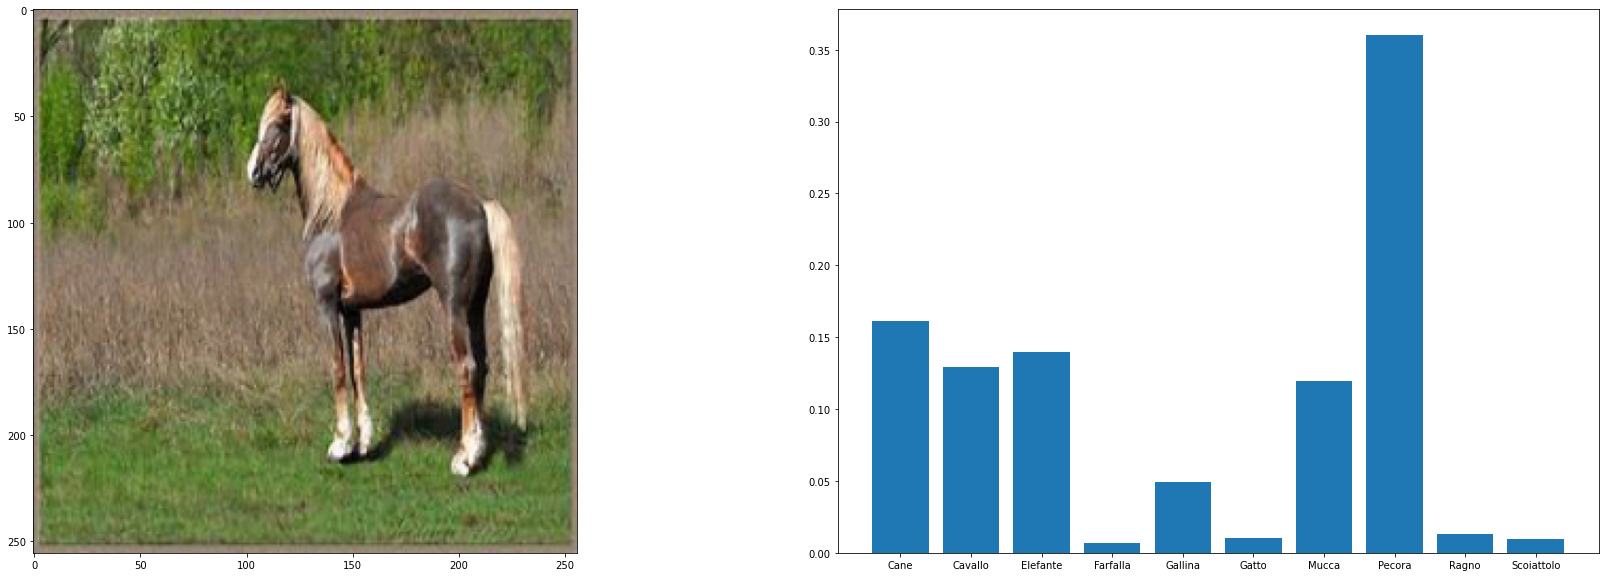

In [ ]:
cane = io.imread("/content/drive/MyDrive/dataset.zip (Unzipped Files)/dataset/test/cane/7.jpg") # -> gatto
scoiattolo = io.imread("/content/drive/MyDrive/dataset.zip (Unzipped Files)/dataset/test/scoiattolo/6.jpg") # -> elefante
mucca = io.imread("/content/drive/MyDrive/dataset.zip (Unzipped Files)/dataset/test/mucca/1.jpg") # -> ragno
farfalla = io.imread("/content/drive/MyDrive/dataset.zip (Unzipped Files)/dataset/test/gallina/6.jpg") # -> farfalla
cavallo = io.imread("/content/drive/MyDrive/dataset.zip (Unzipped Files)/dataset/test/cavallo/1.jpg") # -> gallina

immagini = list()
immagini.append(cane)
immagini.append(scoiattolo)
immagini.append(mucca)
immagini.append(farfalla)
immagini.append(cavallo)

for i in range(len(immagini)):
  immagini[i] = resize(immagini[i], (img_width, img_height,3))

immagini = np.stack(immagini)
predizioni = network.predict(immagini)

labels = list()
labels.append(classes_dictionary['gatto'])
labels.append(classes_dictionary['elefante'])
labels.append(classes_dictionary['ragno'])
labels.append(classes_dictionary['farfalla'])
labels.append(classes_dictionary['gallina'])
labels = np.concatenate(labels, 0)

esempi_avversari = iterative_attack(targeted_attack, immagini, labels, network, 25, 0.01)

predizioni_attacco = network.predict(esempi_avversari)

for i in range(len(immagini)):
  plt.figure(figsize=(30,10))
  #plt.subplot(141); plt.imshow(immagini[i])
  #plt.subplot(142); plt.bar(range(10), predizioni[i]); plt.xticks(np.arange(10), classes);
  plt.subplot(121); plt.imshow(esempi_avversari[i])
  plt.subplot(122); plt.bar(range(10), predizioni_attacco[i]); plt.xticks(np.arange(10), classes);

## Attacco black box

### Attacco non target

Si valuta l'effetto dell'attacco black box con tecnica FGSM non targeted iterativa su un batch del dataset dedicato per il testing. Il numero di iterazioni dell'attacco e l'ampiezza della perturbazione sono stati scelti sperimentalmente al fine di ottenere le migliori prestazioni possibili. Da notare che esiste un trade-off tra efficacia dell'attacco e distorsione dell'immagine.

success rate: 40.0%


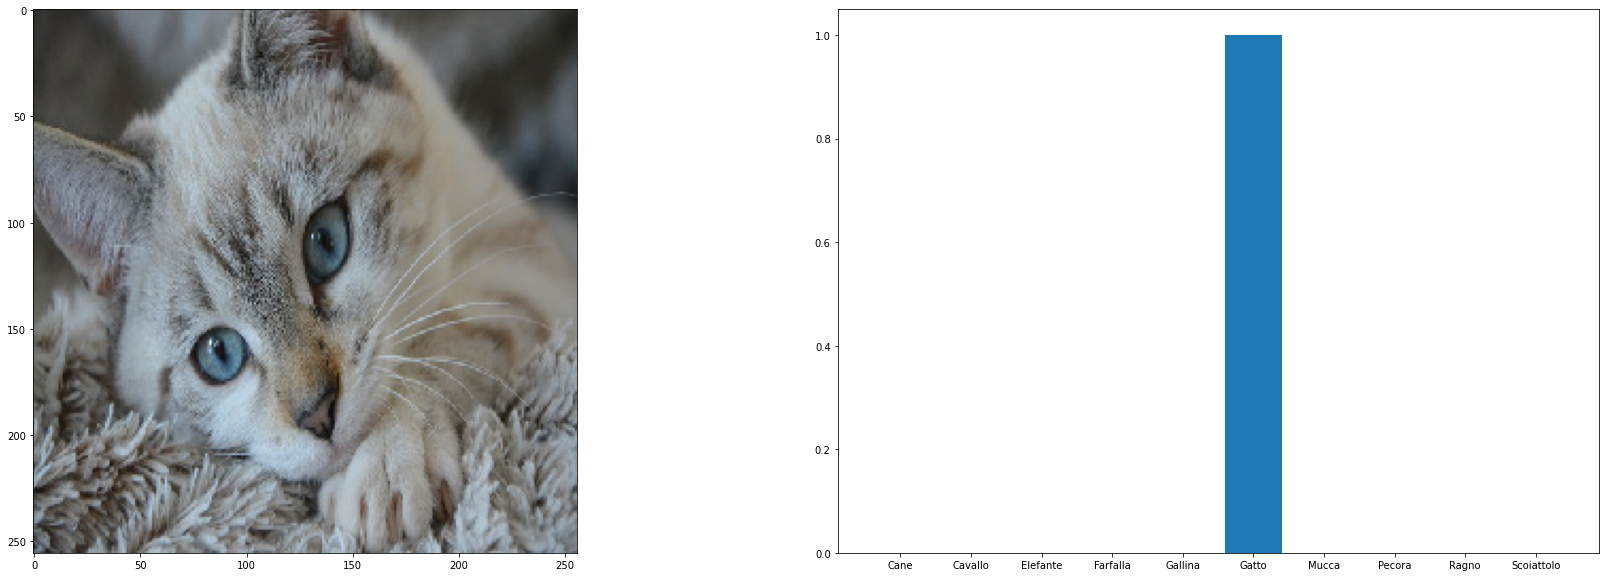

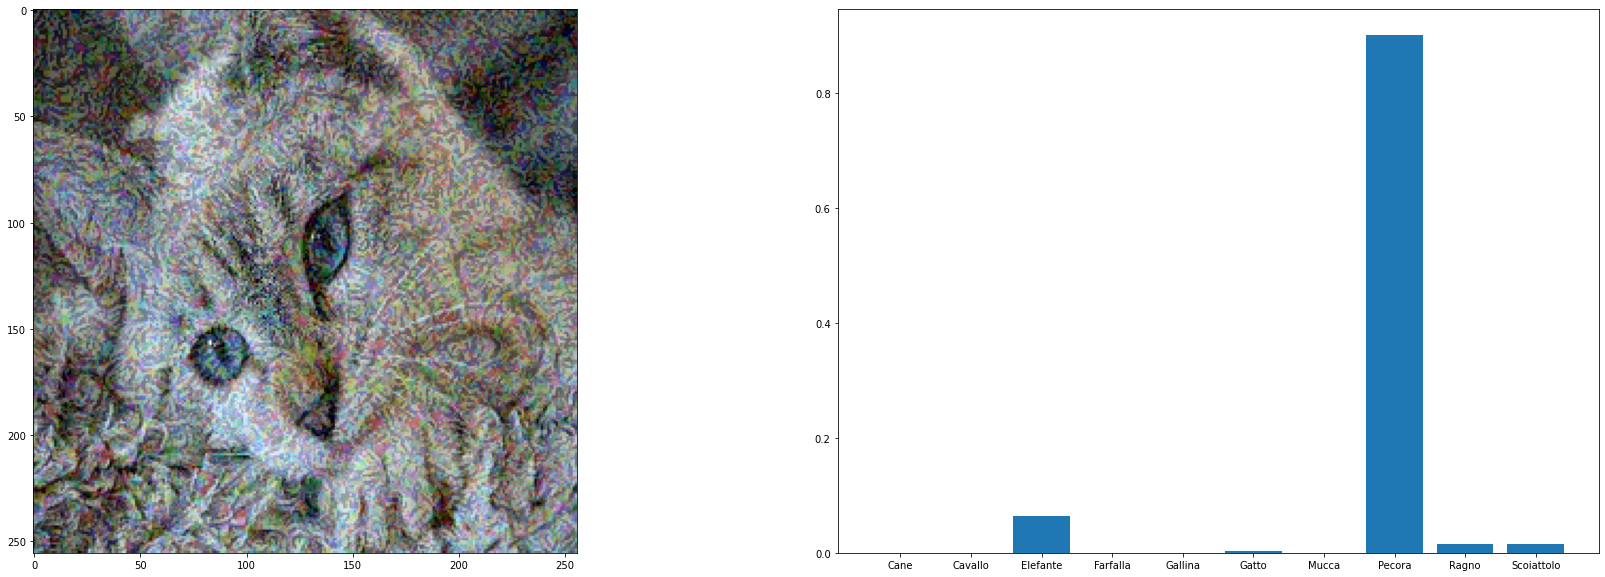

In [ ]:
imgs = next(test_generator)

x_true = imgs[0]
orig_img = x_true[0:10].copy()
fake_img = iterative_attack(non_targeted_attack, orig_img, imgs[1][0:10],network,10,0.13)
pred = bb_network.predict(orig_img)
fake_pred = bb_network.predict(fake_img)

print('success rate: {}%'.format(100*np.mean(np.argmax(pred,-1)!=np.argmax(fake_pred,-1))))

plt.figure(figsize=(30,10))
plt.subplot(121); plt.imshow(orig_img[0])
plt.subplot(122); plt.bar(range(10), pred[0]); plt.xticks(np.arange(10), classes);

plt.figure(figsize=(30,10))
plt.subplot(121); plt.imshow(fake_img[0])
plt.subplot(122); plt.bar(range(10), fake_pred[0]); plt.xticks(np.arange(10), classes);

### Attacco target

Si testano gli esempi avversari costruiti precedentemente tramite il *FGSM targeted* per la rete surrogata e viene verificata la loro efficacia contro la rete black box.

In [ ]:
predizioni_modello_bb = bb_network.predict(esempi_avversari)

for i in range(len(immagini)):
  plt.figure(figsize=(30,10))
  plt.subplot(121); plt.imshow(esempi_avversari[i])
  plt.subplot(122); plt.bar(range(10), predizioni_modello_bb[i]); plt.xticks(np.arange(10), classes);